# 实时负载预测与资源管理 - 高级建模

本笔记本将使用扩展特征集实现更先进的预测模型。基于处理过的数据，我们将探索更复杂的特征工程和模型架构。

In [59]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# 机器学习库
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# 深度学习库
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf_available = True
except ImportError:
    print("警告: TensorFlow不可用，LSTM模型将不可用")
    tf_available = False

# 设置可视化样式
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. 数据加载与探索

In [60]:
# 加载扩展特征集的数据
data_path = '../processed_data/c7_user_ly4HE4d_timeseries.csv'

try:
    df = pd.read_csv(data_path)
    print(f"成功读取数据，形状: {df.shape}")
    
    # 显示前几行数据
    display(df.head())
    
    # 查看数据类型和基本信息
    display(df.info())
    
    # 查看数值特征的统计摘要
    display(df.describe())
    
except Exception as e:
    print(f"读取数据时出错: {e}")

成功读取数据，形状: (4920, 14)


,user,time_dt,collection_id,collection_name,collection_logical_name,start_time_dt,end_time_dt,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour
0,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,1970-01-01 00:00:00.000000,261321454525,h6osjjHIMpr543HMmDYMy10wiLZIvxMLNEDHe07Wix4=,uXg7PS0QinS0hu2jPMkHebkDJpZMywmqm/pOwvdFE5s=,1970-01-04 23:00:00,1970-01-04 23:05:00,0.005669,0.002625,0.000210,0.000698,0.001133,0.000700,1970-01-01 00:00:00
1,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,1970-01-01 00:20:04.269099,275444450369,Q09xPXEsCsFkN7VrsD1YQsX/bMUavURdsKzbJrDERG0=,JpnDNp7PNu0VgS7e15Z4eezBWdZd6iXYQGB6fdODnJs=,1970-01-04 23:55:00,1970-01-05 00:00:00,0.014175,0.003906,0.024353,0.001282,0.048340,0.002674,1970-01-01 00:00:00
2,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,1970-01-01 00:21:08.301086,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 08:15:00,1970-01-01 08:20:00,0.009720,0.002213,0.011749,0.001890,0.023834,0.001942,1970-01-01 00:00:00
3,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,1970-01-01 00:56:04.361849,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 01:45:00,1970-01-01 01:50:00,0.009720,0.002213,0.007622,0.001570,0.014450,0.001663,1970-01-01 00:00:00
4,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,1970-01-01 00:56:04.361851,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 08:15:00,1970-01-01 08:20:00,0.009720,0.002213,0.011749,0.001890,0.023834,0.001942,1970-01-01 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user                     4920 non-null   object 
 1   time_dt                  4920 non-null   object 
 2   collection_id            4920 non-null   int64  
 3   collection_name          4920 non-null   object 
 4   collection_logical_name  4920 non-null   object 
 5   start_time_dt            4920 non-null   object 
 6   end_time_dt              4920 non-null   object 
 7   resource_request_cpu     4920 non-null   float64
 8   resource_request_memory  4920 non-null   float64
 9   average_usage_cpu        4920 non-null   float64
 10  average_usage_memory     4920 non-null   float64
 11  maximum_usage_cpu        4920 non-null   float64
 12  maximum_usage_memory     4920 non-null   float64
 13  hour                     4920 non-null   object 
dtypes: float64(6), int64(1),

None

,collection_id,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory
count,4.920000e+03,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000
mean,2.894396e+11,0.008051,0.002619,0.005840,0.001135,0.014714,0.001335
std,6.769012e+09,0.003478,0.000546,0.007428,0.000657,0.015670,0.000751
min,2.613215e+11,0.002026,0.001017,0.000000,0.000015,0.000000,0.000015
25%,2.857485e+11,0.005669,0.002605,0.000224,0.000658,0.000856,0.000661
50%,2.857485e+11,0.005669,0.002625,0.005203,0.001230,0.014771,0.001415
75%,2.966573e+11,0.008102,0.002625,0.007919,0.001432,0.018646,0.001823
max,2.999960e+11,0.016205,0.005692,0.066650,0.002804,0.135986,0.003090


### 1.1 检查缺失值

In [61]:
# 检查缺失值
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    '缺失值数量': missing_values,
    '缺失百分比': missing_percentage
}).sort_values('缺失百分比', ascending=False)

display(missing_df[missing_df['缺失值数量'] > 0])

,缺失值数量,缺失百分比


### 1.2 时间特征检查与转换

In [62]:
# 检查并转换时间特征
time_columns = [col for col in df.columns if 'time' in col.lower() and 'dt' not in col.lower()]
print(f"时间相关列: {time_columns}")

for col in time_columns:
    if col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
            print(f"转换列 {col} 为日期时间格式")

# 确保有时间序列索引
if 'time_dt' in df.columns:
    # 将时间列设为索引
    df_ts = df.set_index('time_dt').sort_index()
    print("已将时间列设为索引并排序")
    display(df_ts.head())
else:
    print("没有找到time_dt列，检查时间列转换")

时间相关列: []
已将时间列设为索引并排序


,user,collection_id,collection_name,collection_logical_name,start_time_dt,end_time_dt,resource_request_cpu,resource_request_memory,average_usage_cpu,average_usage_memory,maximum_usage_cpu,maximum_usage_memory,hour
time_dt,,,,,,,,,,,,,
1970-01-01 00:00:00.000000,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,261321454525,h6osjjHIMpr543HMmDYMy10wiLZIvxMLNEDHe07Wix4=,uXg7PS0QinS0hu2jPMkHebkDJpZMywmqm/pOwvdFE5s=,1970-01-04 23:00:00,1970-01-04 23:05:00,0.005669,0.002625,0.000210,0.000698,0.001133,0.000700,1970-01-01 00:00:00
1970-01-01 00:20:04.269099,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,275444450369,Q09xPXEsCsFkN7VrsD1YQsX/bMUavURdsKzbJrDERG0=,JpnDNp7PNu0VgS7e15Z4eezBWdZd6iXYQGB6fdODnJs=,1970-01-04 23:55:00,1970-01-05 00:00:00,0.014175,0.003906,0.024353,0.001282,0.048340,0.002674,1970-01-01 00:00:00
1970-01-01 00:21:08.301086,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 08:15:00,1970-01-01 08:20:00,0.009720,0.002213,0.011749,0.001890,0.023834,0.001942,1970-01-01 00:00:00
1970-01-01 00:56:04.361849,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 01:45:00,1970-01-01 01:50:00,0.009720,0.002213,0.007622,0.001570,0.014450,0.001663,1970-01-01 00:00:00
1970-01-01 00:56:04.361851,ly4HE4d+6E8BqXgm6E1eGNKu8OiiZE+Gj/D4YUMRFDU=,275444572542,8nMel5P6Hbohb4HkEtC7rr/XLbXh8gE5odYgwst4wEY=,c3chkYTIgOxBUHA2xWkTkVyPqkdB/bfAYXnKFjJbZlg=,1970-01-01 08:15:00,1970-01-01 08:20:00,0.009720,0.002213,0.011749,0.001890,0.023834,0.001942,1970-01-01 00:00:00


### 1.3 目标变量的分布与时间序列可视化

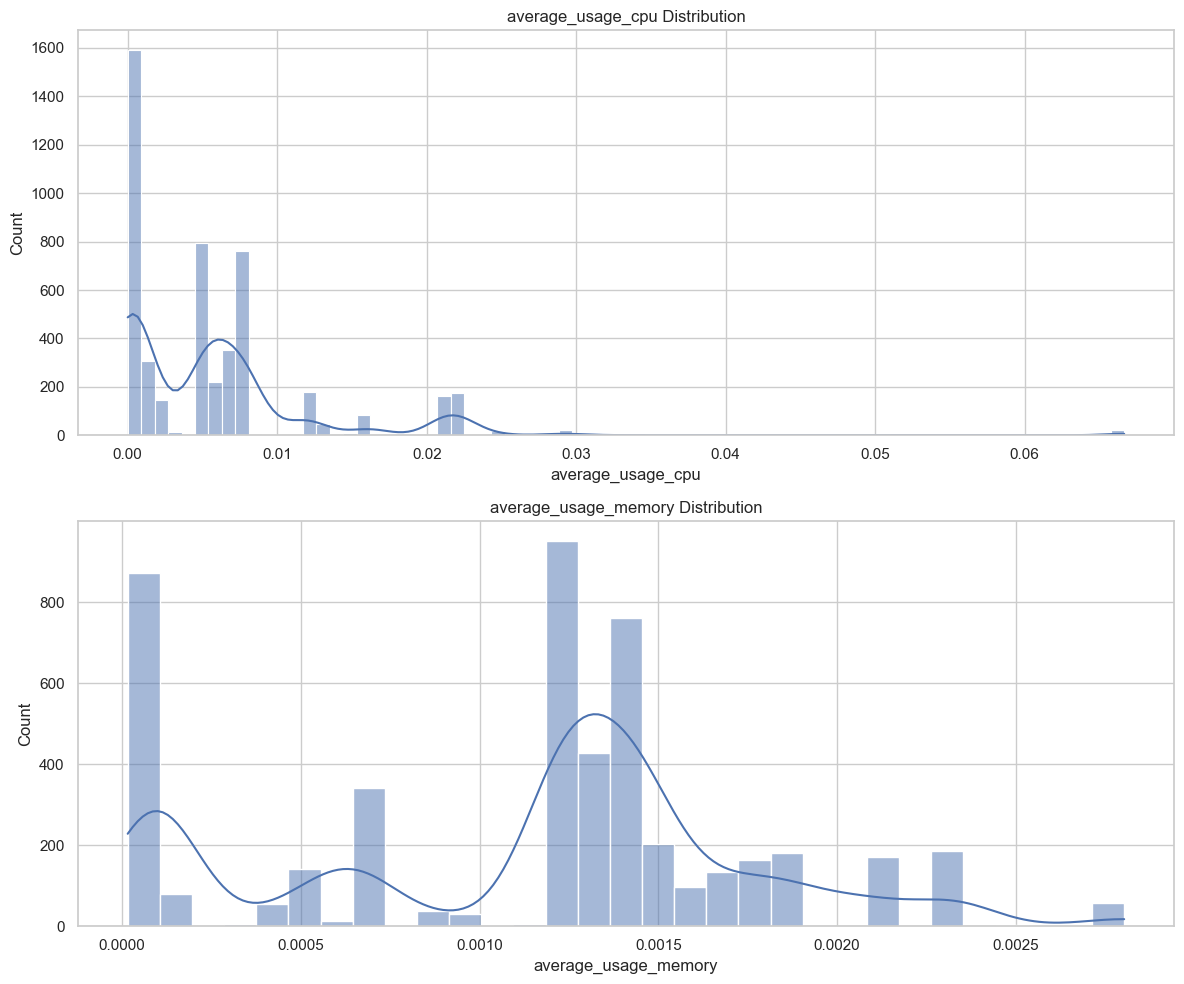

In [63]:
# 定义目标变量 (CPU和内存使用率)
target_vars = ['average_usage_cpu', 'average_usage_memory']

# 检查目标变量是否存在
target_vars = [var for var in target_vars if var in df.columns]

if target_vars:
    # 可视化目标变量分布
    fig, axes = plt.subplots(len(target_vars), 1, figsize=(12, 5*len(target_vars)))
    if len(target_vars) == 1:
        axes = [axes]
        
    for i, var in enumerate(target_vars):
        # 直方图
        sns.histplot(df[var], ax=axes[i], kde=True)
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel(var)
    
    plt.tight_layout()
    plt.show()
    
    # 时间序列可视化
    #if 'time_dt' in df.columns:
    #    fig, axes = plt.subplots(len(target_vars), 1, figsize=(16, 6*len(target_vars)))
    #    if len(target_vars) == 1:
    #        axes = [axes]
            
    #    for i, var in enumerate(target_vars):
    #        axes[i].plot(df['time_dt'], df[var])
    #        axes[i].set_title(f'{var} Time Series')
    #        axes[i].set_xlabel('Time')
    #        axes[i].set_ylabel(var)
        
    #    plt.tight_layout()
    #    plt.show()
else:
    print("目标变量不存在于数据集中，请检查列名")

## 2. 特征工程

基于之前的模型结果和数据分析，我们将创建更多高级特征来提升模型性能。

### 2.1 时间特征创建

In [64]:
# 创建时间特征
def create_time_features(df, time_col='time_dt'):
    """从时间列创建丰富的时间特征"""
    print("\n创建时间特征...")
    
    # 确保列存在
    if time_col not in df.columns:
        print(f"列 {time_col} 不存在")
        return df
    
    # 复制数据框以避免修改原始数据
    df_new = df.copy()
    
    # 确保时间列是datetime类型
    df_new[time_col] = pd.to_datetime(df_new[time_col])
    print(f"转换 {time_col} 为datetime类型")
    
    # 从datetime创建特征
    df_new['hour_of_day'] = df_new[time_col].dt.hour
    df_new['day_of_week'] = df_new[time_col].dt.dayofweek
    df_new['day_of_month'] = df_new[time_col].dt.day
    df_new['month'] = df_new[time_col].dt.month
    
    # 创建周末指标 (0=工作日, 1=周末)
    df_new['is_weekend'] = df_new['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # 创建一天中的时段分类
    def get_day_part(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    df_new['day_part'] = df_new['hour_of_day'].apply(get_day_part)
    
    # 对时段进行独热编码
    df_new = pd.get_dummies(df_new, columns=['day_part'], prefix='day_part')
    
    # 创建小时和日期的周期性特征（正弦和余弦变换）
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['day_of_week'] / 7)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['day_of_week'] / 7)
    
    return df_new

# 应用时间特征创建函数
if 'time_dt' in df.columns:
    df = create_time_features(df)
    print("已创建时间特征")
    
    # 显示新增的时间特征列
    time_feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']
    time_feature_cols = [col for col in time_feature_cols if col in df.columns]
    
    if time_feature_cols:
        display(df[time_feature_cols].head())
else:
    print("无法创建时间特征，缺少time_dt列")


创建时间特征...
转换 time_dt 为datetime类型
已创建时间特征


,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
0,0,3,0,0.0,1.0
1,0,3,0,0.0,1.0
2,0,3,0,0.0,1.0
3,0,3,0,0.0,1.0
4,0,3,0,0.0,1.0


### 2.2 滑动窗口特征（滞后特征）

In [65]:
# 创建滞后特征（基于排序后的时间序列）
def create_lag_features(df, target_cols, lag_periods=[1, 3, 6, 12, 24], sort_col='time_dt'):
    """为目标列创建滞后特征"""
    # 确保数据按时间排序
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # 为每个目标列和每个滞后周期创建特征
    for target in target_cols:
        for lag in lag_periods:
            # 创建滞后特征
            df_sorted[f'{target}_lag_{lag}'] = df_sorted[target].shift(lag)
    
    return df_sorted

# 创建滚动窗口统计特征
def create_rolling_features(df, target_cols, windows=[3, 6, 12, 24], sort_col='time_dt'):
    """为目标列创建滚动窗口统计特征"""
    # 确保数据按时间排序
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # 为每个目标列和每个窗口创建特征
    for target in target_cols:
        for window in windows:
            # 创建滚动平均值
            df_sorted[f'{target}_rolling_mean_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).mean()
            # 创建滚动标准差
            df_sorted[f'{target}_rolling_std_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).std()
            # 创建滚动最小值和最大值
            df_sorted[f'{target}_rolling_min_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).min()
            df_sorted[f'{target}_rolling_max_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).max()
    
    return df_sorted

# 应用滞后和滚动窗口特征创建
if 'time_dt' in df.columns and target_vars:
    # 创建滞后特征
    df = create_lag_features(df, target_vars)
    print("已创建滞后特征")
    
    # 创建滚动窗口特征
    df = create_rolling_features(df, target_vars)
    print("已创建滚动窗口特征")
    
    # 显示新增特征的前几行
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col][:5]
    if lag_cols:
        display(df[lag_cols].head(10))
else:
    print("无法创建时间序列特征，缺少必要的列")

已创建滞后特征
已创建滚动窗口特征


,average_usage_cpu_lag_1,average_usage_cpu_lag_3,average_usage_cpu_lag_6,average_usage_cpu_lag_12,average_usage_cpu_lag_24
0,NaN,NaN,NaN,NaN,NaN
1,0.000210,NaN,NaN,NaN,NaN
2,0.024353,NaN,NaN,NaN,NaN
3,0.011749,0.000210,NaN,NaN,NaN
4,0.007622,0.024353,NaN,NaN,NaN
5,0.011749,0.011749,NaN,NaN,NaN
6,0.011749,0.007622,0.000210,NaN,NaN
7,0.011749,0.011749,0.024353,NaN,NaN
8,0.007622,0.011749,0.011749,NaN,NaN
9,0.024353,0.011749,0.007622,NaN,NaN


## 3. 准备模型训练数据

In [68]:
def prepare_data_for_modeling(df, target_vars):
    """准备模型训练数据"""
    print("\n准备模型训练数据...")
    
    # 处理缺失值
    print("处理缺失值...")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                # 数值型列用中位数填充
                df[col] = df[col].fillna(df[col].median())
            else:
                # 非数值型列用众数填充
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # 删除无用列
    cols_to_drop = []
    
    # 删除高基数ID列
    id_cols = [col for col in df.columns if 'id' in col.lower() or 'name' in col.lower() or 'user' in col.lower()]
    cols_to_drop.extend(id_cols)
    
    # 删除原始时间戳列（保留转换后的dt列）
    timestamp_cols = [col for col in df.columns if ('time' in col.lower() and 'dt' not in col.lower())]
    cols_to_drop.extend(timestamp_cols)
    
    # 排除目标变量
    cols_to_drop = [col for col in cols_to_drop if col not in target_vars]
    
    # 删除全是NaN的列
    null_cols = df.columns[df.isnull().all()].tolist()
    cols_to_drop.extend(null_cols)
    
    # 删除列
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    print(f"删除了 {len(cols_to_drop)} 列")
    
    # 将分类变量转换为数值
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        if col not in target_vars:  # 不转换目标变量
            # 对分类变量进行标签编码
            df[col] = pd.factorize(df[col])[0]
    
    print("数据准备完成")
    return df

df = prepare_data_for_modeling(df, target_vars)


准备模型训练数据...
处理缺失值...
删除了 4 列
数据准备完成


### 4. 构建模型

In [69]:
# 5. 可视化预测结果
xgb_model = None
scaler = None
def visualize_predictions_separate(y_true, predictions_dict, title_prefix="Prediction Comparison"):
    """Create a separate prediction vs true value comparison chart for each model"""

    # First, create an overview chart containing all models
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')

    for model_name, preds in predictions_dict.items():
        plt.plot(range(len(preds)), preds, '--', label=f'{model_name} Prediction')

    plt.title(f"{title_prefix} - Overview")
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"{title_prefix.replace(' ', '_')}_overview.png")
    plt.show()

    # Then, create a separate chart for each model
    for model_name, preds in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')
        plt.plot(range(len(preds)), preds, 'r--', label=f'{model_name} Prediction')

        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig(f"{title_prefix.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.show()

    print(f"Created {len(predictions_dict) + 1} prediction comparison charts")

# 4. 模型构建与评估
def evaluate_models(df, target_var, test_size=0.2, random_state=42):
    """Build and evaluate multiple prediction models"""
    print(f"\nEvaluating prediction models for {target_var}...")
    #global xgb_model, scaler
    global X_train_scaled
    # Prepare features and target
    y = df[target_var]
    X = df.drop(columns=[col for col in df.columns if col in [target_var] or col.startswith('time_')])

    print(f"Feature count: {X.shape[1]}")
    print(f"Sample count: {X.shape[0]}")

    # Create training and testing sets (time series split)
    # To ensure we don't use future data to predict the past, use the last test_size proportion of data as the test set
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model result storage
    model_results = []

    # 1. Random forest
    print("\nTraining Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf.fit(X_train_scaled, y_train)

    # Predict
    rf_preds = rf.predict(X_test_scaled)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    mae = mean_absolute_error(y_test, rf_preds)
    r2 = r2_score(y_test, rf_preds)

    print(f"Random Forest - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    model_results.append({"model": "Random Forest", "rmse": rmse, "mae": mae, "r2": r2})

    # Summarize results
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('rmse')

    print("\nModel performance summary:")
    print(results_df)

    # 可视化预测结果
    # 收集预测结果用于可视化
    predictions_dict = {}
    if 'rf_preds' in locals():
        predictions_dict['Random Forest'] = rf_preds

    visualize_predictions_separate(
        y_true=y_test,
        predictions_dict=predictions_dict,
        title_prefix=f"{target_var} Prediction Comparison"
    )

    # Return the best model and evaluation results
    return results_df


Evaluating prediction models for average_usage_cpu...
Feature count: 45
Sample count: 4920
Training set shape: (3936, 45), Test set shape: (984, 45)

Training Random Forest...
Random Forest - RMSE: 0.002298, MAE: 0.001182, R²: 0.404771

Model performance summary:
           model      rmse       mae        r2
0  Random Forest  0.002298  0.001182  0.404771


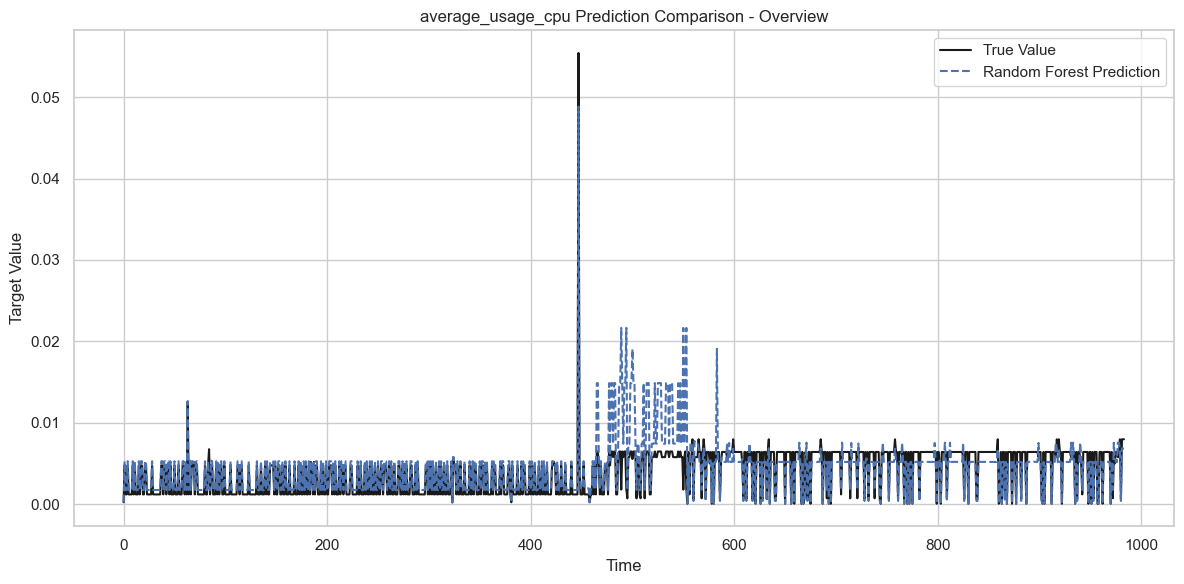

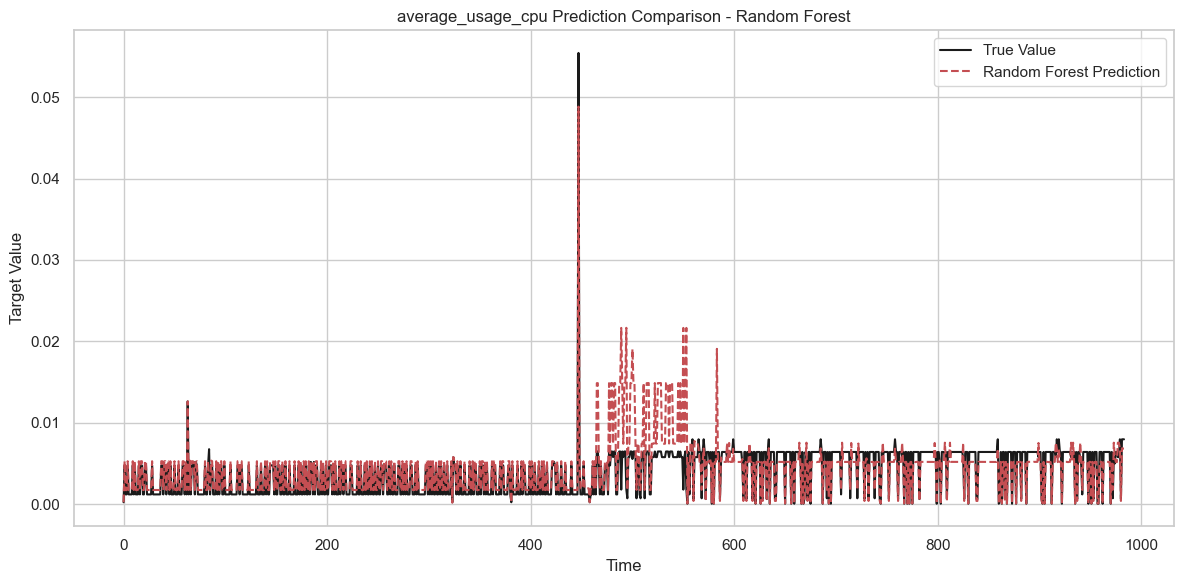

Created 2 prediction comparison charts

Evaluating prediction models for average_usage_memory...
Feature count: 45
Sample count: 4920
Training set shape: (3936, 45), Test set shape: (984, 45)

Training Random Forest...
Random Forest - RMSE: 0.000222, MAE: 0.000190, R²: 0.838031

Model performance summary:
           model      rmse      mae        r2
0  Random Forest  0.000222  0.00019  0.838031


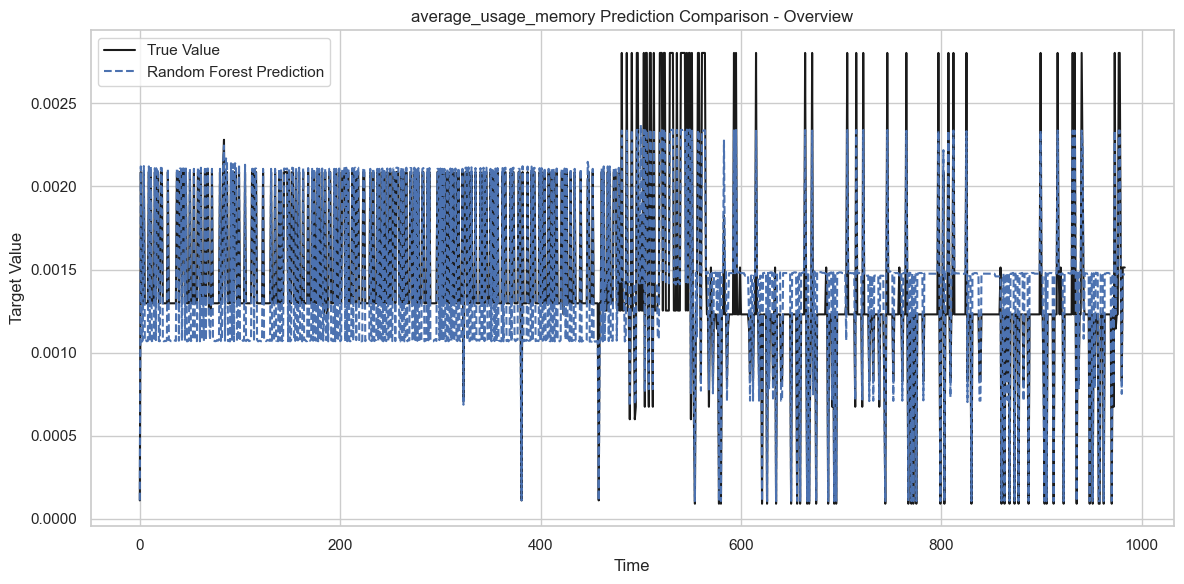

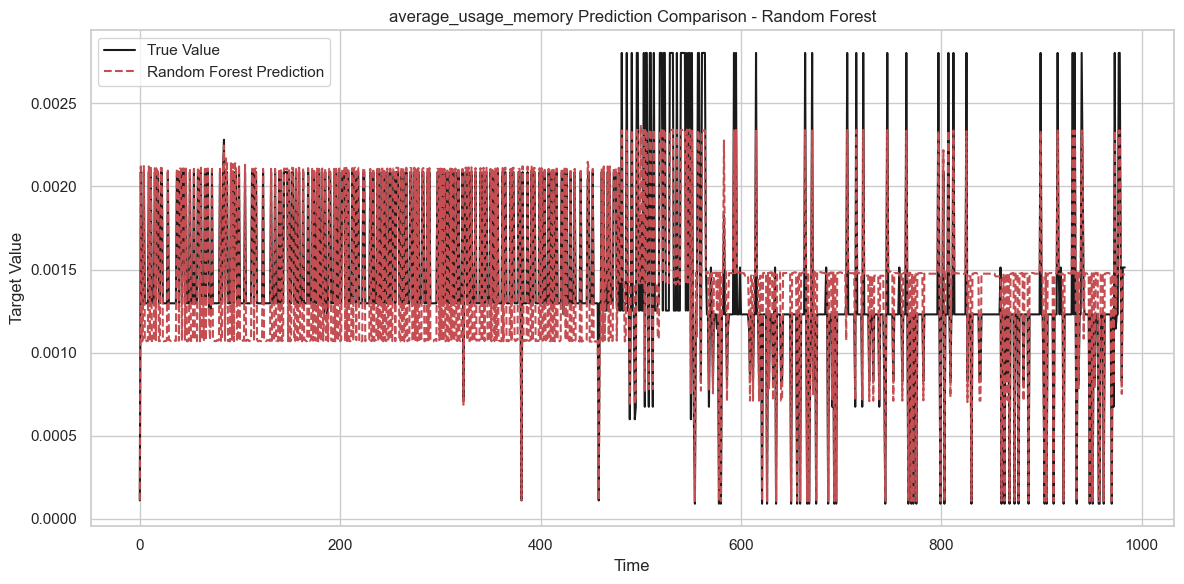

Created 2 prediction comparison charts
建模完成！


In [70]:
for target_var in target_vars:
    # 过滤掉含有NaN的行
    df_clean = df.dropna(subset=[target_var])

    # 过滤掉其他目标变量的滞后特征
    other_targets = [t for t in target_vars if t != target_var]
    cols_to_drop = []
    for other_target in other_targets:
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_lag_")])
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_rolling_")])

    df_model = df_clean.drop(columns=cols_to_drop, errors='ignore')
    # 构建和评估模型
    results_df = evaluate_models(df_model, target_var)
    #results_df.to_csv(f"model_results_{target_var}.csv", index=False)
print("建模完成！")